In [1]:
import os
import sys

path_to_research = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

if path_to_research not in sys.path:
    sys.path.insert(0, path_to_research)

print(f"sys.path: {path_to_research}")

sys.path: /home/emanu/ubuntu/ita/HardnessMDL/research


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


In [3]:
def create_folder_plots(folder_path: str, num_datasets: int = 4):
  fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
  fig.suptitle(f'Scatter Plots of {folder_path}')
  
  for i in range(num_datasets):
    df = pd.read_csv(f"{folder_path}test{i+1}.csv")
    sns.scatterplot(ax=axes[i], data=df, x='X', y='Y', hue='class')
    axes[i].set_title(f'DataFrame {i+1}')
  
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
  plt.show()



def transform_dl_string_to_columns(df: pd.DataFrame) -> pd.DataFrame: 
    df_copy = df.copy() # without side-effects

    df_copy["description_lengths_list"] = df_copy["description_lengths"].apply(
        lambda x: [float(i) for i in x.strip("[]").split(" ") if i]
    )

    description_lengths_columns = pd.DataFrame(
        df_copy["description_lengths_list"].tolist(),
        columns=[f"L_{i}" for i in range(len(df_copy["description_lengths_list"].iloc[0]))],
        index=df_copy.index
    )

    return pd.concat([df_copy.drop(columns=["description_lengths_list"]), description_lengths_columns], axis=1)


In [4]:
def plot_hardness(dfs: list, hardness_measure: str):
  
  df_meta_feats_dict = {}
  for i, df in enumerate(dfs):
      df_meta_feats_dict[f'DataFrame {i+1}'] = df

  fig = make_subplots(rows=1, cols=4, subplot_titles=(
      "DataFrame 1",
      "DataFrame 2",
      "DataFrame 3",
      "DataFrame 4"
  ))

  for i, df in enumerate(dfs):
      df_name = f'DataFrame {i+1}'
      dcp_values = df_meta_feats_dict[df_name][hardness_measure]

      fig.add_trace(go.Scattergl(x=df["X"], y=df["Y"], mode='markers',
                              marker=dict(color=dcp_values,
                                          colorscale='viridis',
                                          cmin=0, cmax=1, 
                                          showscale=True if i == 3 else False, 
                                          colorbar=dict(title=hardness_measure, x=1.02)),
                              name=df_name),
                    row=1, col=i+1)

  fig.update_layout(title_text=f"Scatter Plots of DataFrames 1 to 4: {hardness_measure}", showlegend=False)
  fig.show()

In [5]:
def compute_hardness_measures(df):
    # Identify L_* columns
    l_cols = [col for col in df.columns if col.startswith('L_')]
    n_classes = len(l_cols)
    
    def row_hardness(row):
        description_lengths = np.array([row[col] for col in l_cols])
        label = int(row['true_label'])

        r_min = min(1, description_lengths[label] / np.min(np.delete(description_lengths, label)))

        r_med = min(1, description_lengths[label] / np.mean(np.delete(description_lengths, label)))

        rel_pos = (description_lengths[label] - np.min(description_lengths)) / (
            np.max(description_lengths) - np.min(description_lengths)
        )

        pseudo_probs = np.exp2(-description_lengths)
        pseudo_prob = 1 - pseudo_probs[label] / np.sum(pseudo_probs)

        H = np.dot(pseudo_probs, description_lengths)
        norm_entropy = H / n_classes

        return pd.Series({
            'r_min': r_min,
            'r_med': r_med,
            'relative_position': rel_pos,
            'pseudo_probability': pseudo_prob,
            'normalized_entropy': norm_entropy
        })

    return df.join(df.apply(row_hardness, axis=1))



In [6]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
  return compute_hardness_measures(transform_dl_string_to_columns(df))

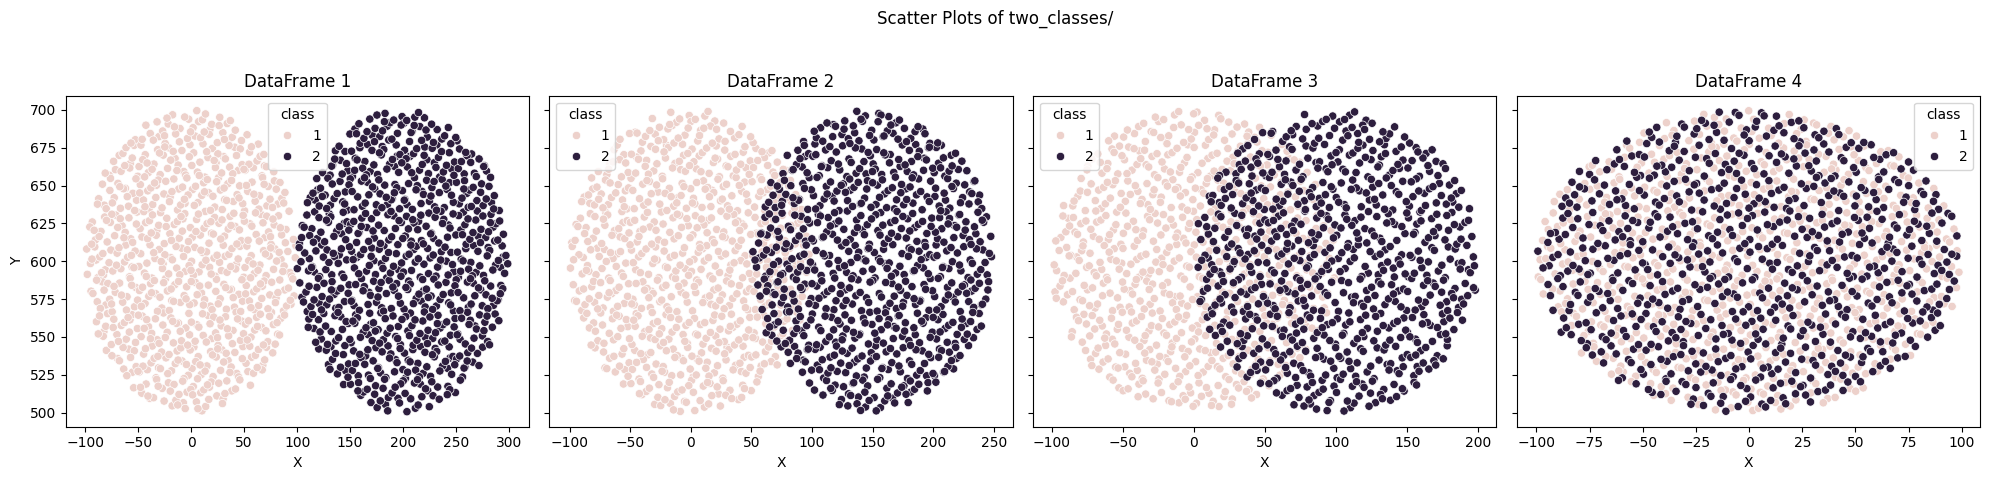

In [7]:
create_folder_plots("two_classes/")

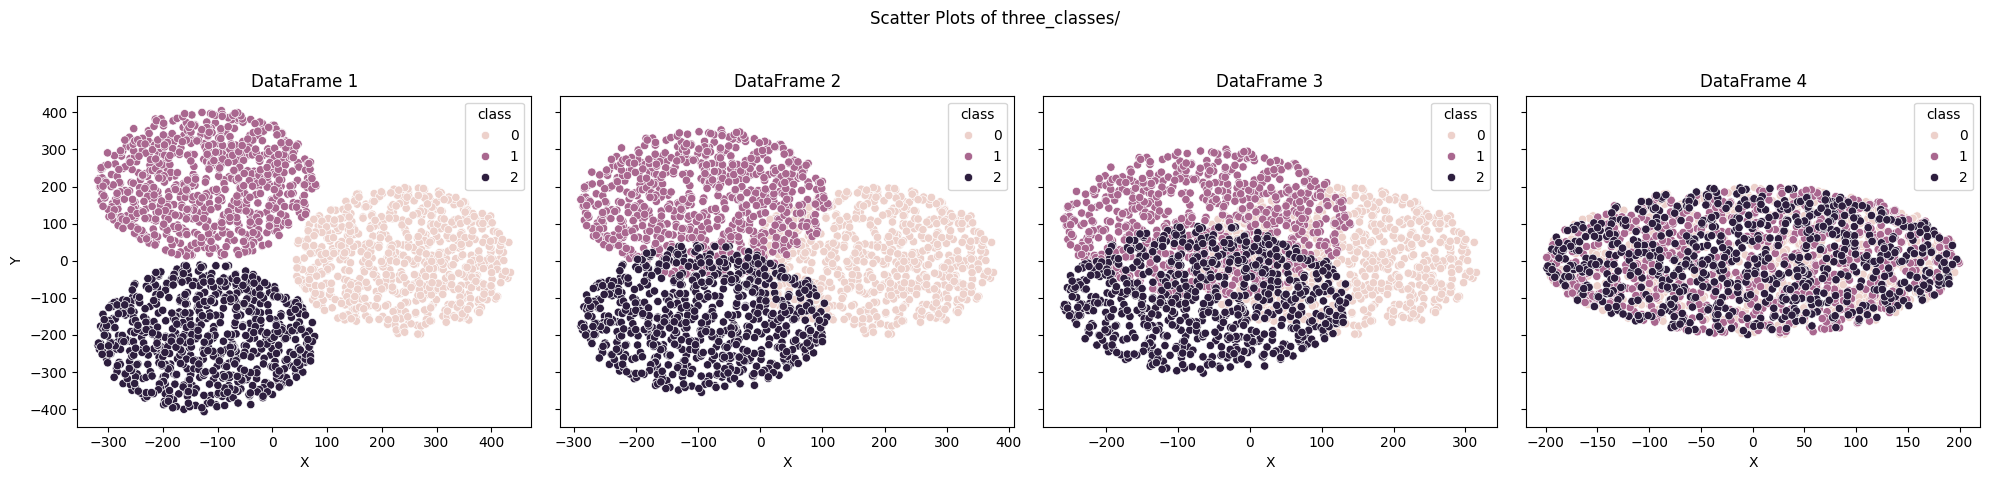

In [8]:
create_folder_plots("three_classes/")

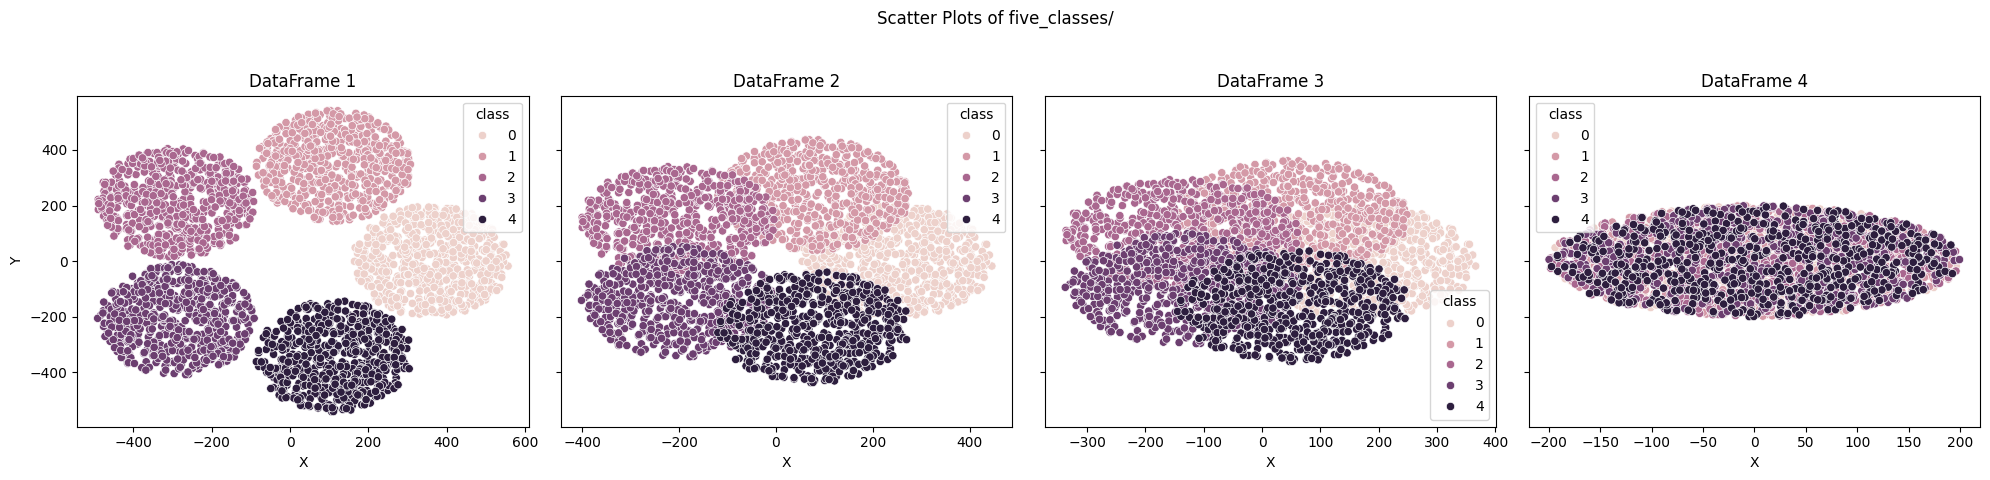

In [9]:
create_folder_plots("five_classes/")

In [10]:
feature_columns = ['X', 'Y']
label_column = 'class'

In [11]:
df2_1 = process_df(pd.read_csv('two_classes/results/test1_description_lenght.csv'))
df2_2 = process_df(pd.read_csv('two_classes/results/test2_description_lenght.csv'))
df2_3 = process_df(pd.read_csv('two_classes/results/test3_description_lenght.csv'))
df2_4 = process_df(pd.read_csv('two_classes/results/test4_description_lenght.csv'))

df3_1 = process_df(pd.read_csv('three_classes/results/test1_description_lenght.csv'))
df3_2 = process_df(pd.read_csv('three_classes/results/test2_description_lenght.csv'))
df3_3 = process_df(pd.read_csv('three_classes/results/test3_description_lenght.csv'))
df3_4 = process_df(pd.read_csv('three_classes/results/test4_description_lenght.csv'))

df5_1 = process_df(pd.read_csv('five_classes/results/test1_description_lenght.csv'))
df5_2 = process_df(pd.read_csv('five_classes/results/test2_description_lenght.csv'))
df5_3 = process_df(pd.read_csv('five_classes/results/test3_description_lenght.csv'))
df5_4 = process_df(pd.read_csv('five_classes/results/test4_description_lenght.csv'))


### Plotting Hardness

In [12]:
dfs_2 = [df2_1, df2_2, df2_3, df2_4]
dfs_3 = [df3_1, df3_2, df3_3, df3_4]
dfs_5 = [df5_1, df5_2, df5_3, df5_4]

#### r_min

In [29]:
plot_hardness(dfs=dfs_2, hardness_measure='r_min')

In [30]:
plot_hardness(dfs=dfs_3, hardness_measure='r_min')

In [31]:
plot_hardness(dfs=dfs_5, hardness_measure='r_min')

#### r_med

In [32]:
plot_hardness(dfs=dfs_2, hardness_measure='r_med')

In [33]:
plot_hardness(dfs=dfs_3, hardness_measure='r_med')

In [34]:
plot_hardness(dfs=dfs_5, hardness_measure='r_med')

#### relative_position

In [35]:
plot_hardness(dfs=dfs_2, hardness_measure='relative_position')

In [36]:
plot_hardness(dfs=dfs_3, hardness_measure='relative_position')

In [37]:
plot_hardness(dfs=dfs_5, hardness_measure='relative_position')

#### pseudo_probability

In [38]:
plot_hardness(dfs=dfs_2, hardness_measure='pseudo_probability')

In [39]:
plot_hardness(dfs=dfs_3, hardness_measure='pseudo_probability')

In [40]:
plot_hardness(dfs=dfs_5, hardness_measure='pseudo_probability')

#### normalized_entropy

In [41]:
plot_hardness(dfs=dfs_2, hardness_measure='normalized_entropy')

In [42]:
plot_hardness(dfs=dfs_3, hardness_measure='pseudo_probability')

In [43]:
plot_hardness(dfs=dfs_5, hardness_measure='pseudo_probability')